In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#function to read load data and weather data:
def data_reader(file_name):
    data = pd.read_excel(file_name, parse_dates=True, index_col='Time', usecols=range(2))
    return data

def weather_reader(file_name):
    weather = pd.read_excel(file_name, parse_dates=True, index_col='Time measured')
    return weather

#function for concatenating load data and weather data for training:
def data(file_name_load, file_name_weather):
    train_data = pd.concat([file_name_load, file_name_weather], axis=1)
    return train_data

In [3]:
load_data = data_reader('Index_Bjønntjønn_2014_2018.xlsx')
weather_data = weather_reader('bo_temp_2014_2018.xlsx')

weather_data = weather_data.interpolate()
training = data(load_data, weather_data)
#print(training.head())

#Renaming columns for easier interpreting:
training = training.rename(columns={"Total":"Load","Middeltemperatur i 2m høyde (TM)": "Temperature"})
training.describe()

#Binary series to distuinguish working days from holidays by 1 and 0:
s = pd.date_range('2014-01-01', '2019-01-01', freq='H').to_series()
training['weekday'] = s.dt.dayofweek
#training['weekday'] = training['weekday'].astype(int)
training['working_days'] = training['weekday'].replace({6: 1, 5: 1, 4: 1, 3: 0, 2: 0, 1: 0})

In [4]:
#function to create sliding window based on time shifts:
def time_shifts_func(name, data_hrs, time_shift, regr=False):
    # name = 'DK1'
    # time_shift = 24
    if not regr:
        data_hrs[name + '_t' + '+' + str(time_shift)] = data_hrs[name].shift(time_shift)
    else:
        data_hrs['auto_' + name + '_t' + '+' + str(time_shift)] = (data_hrs[name].shift(time_shift)-data_hrs[name].shift(time_shift+1))
    #print(data_hrs[name].shift(time_shift))
    #data_hours['DK1_t+24'] = data_hours[name].shift(+24)
    #data_hours['DK1_t+168'] = data_hours[name].shift(+168)
    #data_hours['DK1_t-24'] = data_hours[name].shift(-24)
    #return data_hrs
time_shifts_func('Load', training, 1)
time_shifts_func('Load', training, 2)   
time_shifts_func('Load', training, 24)
time_shifts_func('Temperature', training, 24)
#time_shifts_func('Load - kWh', training, 168)
#time_shifts_func('Load - kWh', training,  24, regr=True)
#time_shifts_func('Load - kWh', training,  1, regr=True)

#training=training.dropna()

In [5]:
training.head(10)

,Load,Temperature,weekday,working_days,Load_t+1,Load_t+2,Load_t+24,Temperature_t+24
2014-01-01 01:00:00,227.0,2.9,2.0,0.0,NaN,NaN,NaN,NaN
2014-01-01 02:00:00,216.0,3.0,2.0,0.0,227.0,NaN,NaN,NaN
2014-01-01 03:00:00,197.0,3.0,2.0,0.0,216.0,227.0,NaN,NaN
2014-01-01 04:00:00,198.0,3.1,2.0,0.0,197.0,216.0,NaN,NaN
2014-01-01 05:00:00,198.0,3.5,2.0,0.0,198.0,197.0,NaN,NaN
2014-01-01 06:00:00,193.0,4.1,2.0,0.0,198.0,198.0,NaN,NaN
2014-01-01 07:00:00,185.0,4.3,2.0,0.0,193.0,198.0,NaN,NaN
2014-01-01 08:00:00,192.0,4.2,2.0,0.0,185.0,193.0,NaN,NaN
2014-01-01 09:00:00,196.0,4.2,2.0,0.0,192.0,185.0,NaN,NaN
2014-01-01 10:00:00,231.0,3.7,2.0,0.0,196.0,192.0,NaN,NaN


In [6]:
def show_plots(data, time_start, time_end=None):
    fig, ax = plt.subplots(figsize=(8,6))
    ax2 = ax.twinx()
    load = data['Load'].loc[time_start:time_end].plot(c='seagreen', label='Load', ax=ax)
    temp = data['Temperature'].loc[time_start:time_end].plot(c='darkorange', label='Temperature', ax=ax2)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.set_ylabel('Load', fontsize=12, fontweight='bold', color='seagreen')
    ax2.set_ylabel('Temperature', fontsize=12, fontweight='bold', color='darkorange')
    fig.tight_layout()
    plt.show()
    return

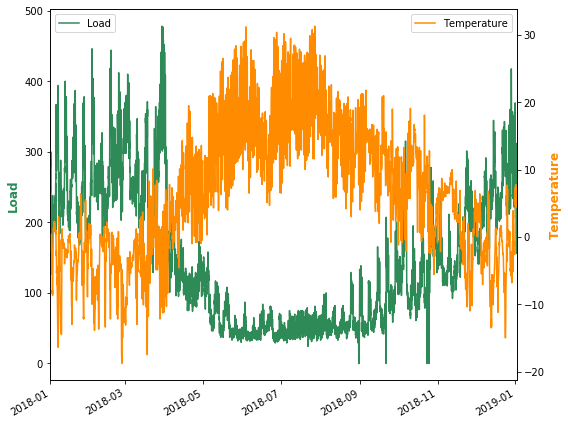

In [7]:
# Time-series for 2018
show_plots(training, '2018')

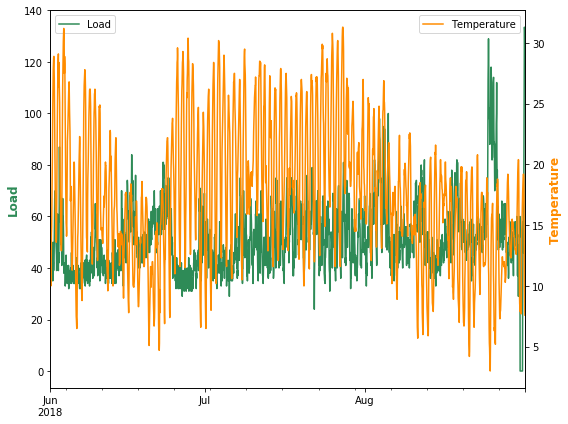

In [8]:
# Time-series for June to August 2018
show_plots(training, '2018-06', '2018-08')

In [9]:
def engineer_features(dataframe, columns, time_lags=24, drop_nan_rows=True):
    data = dataframe[columns].copy()
    # Features engineering
    for col in data.columns:
        for i in range(1, time_lags+1):
            # Shift data by lag of 1 to time_lags (default: 24) hours
            data[col+'_{:d}h'.format(i)] = data[col].shift(periods=i)  # time-lag
        data[col+'_diff'] = data[col].diff()  # first-difference
        data[col+'_week'] = data[col].shift(periods=24*7)  # previous week
    # Hour-of-day indicators with cyclical transform
    dayhour_ind = data.index.hour
    data['hr_sin'] = np.sin(dayhour_ind*(2.*np.pi/24))
    data['hr_cos'] = np.cos(dayhour_ind*(2.*np.pi/24))
    # Day-of-week indicators with cyclical transform
    weekday_ind = data.index.weekday
    data['week_sin'] = np.sin(weekday_ind*(2.*np.pi/7))
    data['week_cos'] = np.cos(weekday_ind*(2.*np.pi/7))
    # Weekend indicator
    data['weekend'] = np.asarray([0 if ind <= 4 else 1 for ind in weekday_ind])
    # Month indicators with cyclical transform
    month_ind = data.index.month
    data['mnth_sin'] = np.sin((month_ind-1)*(2.*np.pi/12))
    data['mnth_cos'] = np.cos((month_ind-1)*(2.*np.pi/12))
    if drop_nan_rows:
        # Drop rows with NaN values
        data.dropna(inplace=True)
    return data

In [10]:
data_features = engineer_features(training, columns=['Load', 'Temperature'])
data_features.head()

,Load,Temperature,Load_1h,Load_2h,Load_3h,Load_4h,Load_5h,Load_6h,Load_7h,Load_8h,...,Temperature_24h,Temperature_diff,Temperature_week,hr_sin,hr_cos,week_sin,week_cos,weekend,mnth_sin,mnth_cos
2014-01-08 01:00:00,129.0,1.7,140.0,144.0,140.0,140.0,135.0,137.0,133.0,133.0,...,2.0,-0.6,2.9,0.258819,0.965926,0.974928,-0.222521,0,0.0,1.0
2014-01-08 02:00:00,137.0,1.4,129.0,140.0,144.0,140.0,140.0,135.0,137.0,133.0,...,2.5,-0.3,3.0,0.500000,0.866025,0.974928,-0.222521,0,0.0,1.0
2014-01-08 03:00:00,129.0,1.7,137.0,129.0,140.0,144.0,140.0,140.0,135.0,137.0,...,3.4,0.3,3.0,0.707107,0.707107,0.974928,-0.222521,0,0.0,1.0
2014-01-08 04:00:00,138.0,1.8,129.0,137.0,129.0,140.0,144.0,140.0,140.0,135.0,...,3.7,0.1,3.1,0.866025,0.500000,0.974928,-0.222521,0,0.0,1.0
2014-01-08 05:00:00,136.0,2.1,138.0,129.0,137.0,129.0,140.0,144.0,140.0,140.0,...,4.7,0.3,3.5,0.965926,0.258819,0.974928,-0.222521,0,0.0,1.0


In [11]:
print(data_features.columns)

Index(['Load', 'Temperature', 'Load_1h', 'Load_2h', 'Load_3h', 'Load_4h',
       'Load_5h', 'Load_6h', 'Load_7h', 'Load_8h', 'Load_9h', 'Load_10h',
       'Load_11h', 'Load_12h', 'Load_13h', 'Load_14h', 'Load_15h', 'Load_16h',
       'Load_17h', 'Load_18h', 'Load_19h', 'Load_20h', 'Load_21h', 'Load_22h',
       'Load_23h', 'Load_24h', 'Load_diff', 'Load_week', 'Temperature_1h',
       'Temperature_2h', 'Temperature_3h', 'Temperature_4h', 'Temperature_5h',
       'Temperature_6h', 'Temperature_7h', 'Temperature_8h', 'Temperature_9h',
       'Temperature_10h', 'Temperature_11h', 'Temperature_12h',
       'Temperature_13h', 'Temperature_14h', 'Temperature_15h',
       'Temperature_16h', 'Temperature_17h', 'Temperature_18h',
       'Temperature_19h', 'Temperature_20h', 'Temperature_21h',
       'Temperature_22h', 'Temperature_23h', 'Temperature_24h',
       'Temperature_diff', 'Temperature_week', 'hr_sin', 'hr_cos', 'week_sin',
       'week_cos', 'weekend', 'mnth_sin', 'mnth_cos'],
      d

In [12]:
#Local holidays including prior knowledge about recreation days
#easter 2014
Training['working_days'].loc['2014-04-14':'2014-04-21']=1
#1st of may 2014
Training['working_days'].loc['2014-05-01']=1
#Pentecost 2014
Training['working_days'].loc['2014-06-07':'2014-06-10']=1
#X-mas 2014
Training['working_days'].loc['2014-12-21':'2014-12-31']=1
#1st of January 2015
Training['working_days'].loc['2015-01-01']
#easter 2015 
Training['working_days'].loc['2015-03-30':'2015-04-06']=1
#1st of may 2015 is on a friday, already coded 
#Training['working_days'].loc['2015-05-01']=1
#Ascension Day 2015 2015-05-14
Training['working_days'].loc['2015-05-14']=1
#Pentecost 2015
Training['working_days'].loc['2014-05-24':'2014-05-25']=1
#X-mas 2015
Training['working_days'].loc['2015-12-23':'2015-12-31']=1
#1st of January 2016
Training['working_days'].loc['2016-01-01']=1
#easter 2016
Training['working_days'].loc['2016-03-21':'2016-03-28']=1
#1st of may 2016 is on a sunday, already coded 
#Training['working_days'].loc['2015-05-01']=1
#Ascension Day 2016 2015-05-16
Training['working_days'].loc['2016-05-05']=1
#Pentecost 2016
Training['working_days'].loc['2016-05-16':'2016-05-17']=1
#X-mas 2016
Training['working_days'].loc['2016-12-26':'2016-12-31']=1
#1st of January 2017
Training['working_days'].loc['2017-01-01']
#easter 2017
Training['working_days'].loc['2017-04-10':'2017-04-17']=1
#1st of may 2017 is on a monday:
Training['working_days'].loc['2017-05-01']=1
#17th of may 2017 is on a wednesday:
Training['working_days'].loc['2017-05-17']=1
#Ascension Day 2017 2017-05-25
Training['working_days'].loc['2017-05-25']=1
#Pentecost 2017
Training['working_days'].loc['2017-06-05']=1
#X-mas 2017
Training['working_days'].loc['2017-12-25':'2017-12-31']=1
#1st of January 2018
Training['working_days'].loc['2018-01-01']
#easter 2018
Training['working_days'].loc['2018-03-26':'2018-04-02']=1
#1st of may 2018 is on a tuesday:
Training['working_days'].loc['2018-05-01']=1
#Ascension Day 2018 2018-05-10
Training['working_days'].loc['2017-05-10']=1
#17th of may 2018 is on a thursday:
Training['working_days'].loc['2017-05-17']=1
#Pentecost 2018
Training['working_days'].loc['2018-05-21']=1
#X-mas 2018
Training['working_days'].loc['2018-12-24':'2018-12-31']=1